In [1]:
from pyspark.sql.types import Row

In [2]:
data=spark.read.csv("kc_house_95_data.csv")# reading the csv file


In [3]:
data.printSchema() # printing Schema from the data 

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)



In [4]:
# taking an observation and convert each one of the elements to float
def convert_to_numbers(my_tuple):
    my_list=[]
    for element in my_tuple:
        my_list.append(float(element))
    return tuple(my_list)

In [5]:
#concat 2 tuples together 
def concat_tuples(tuple1,tuple2):
    all_elements=[]
    for element in tuple1:
        all_elements.append(element)
    for element in tuple2:
        all_elements.append(element)
    return tuple(all_elements)
concat_tuples((12,31,14),("rabi","tal",'roi'))

(12, 31, 14, 'rabi', 'tal', 'roi')

In [6]:
def delete_row(row,place):
    my_list=list(row)
    my_list.pop(place)
    return tuple(my_list)

In [7]:
delete_row((4,2,4,"rabi",'tal'),4)

(4, 2, 4, 'rabi')

In [8]:
print(data)

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string]


In [9]:
rdd=data.select("_c1","_c2","_c3","_c4","_c6","_c7","_c8","_c9","_c10","_c11","_c12","_c13","_c14","_c15","_c19","_c20").rdd.map(lambda row:(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14],row[15]))

In [10]:
#rdd=data.select("_c0","_c1").rdd.map(lambda row:(row[0],row[1]))

In [11]:
rdd.toDF().show()

+---------------+--------+--------+---------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------------+----------+
|             _1|      _2|      _3|       _4|      _5|    _6|        _7|  _8|       _9|  _10|       _11|          _12|     _13|         _14|          _15|       _16|
+---------------+--------+--------+---------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------------+----------+
|           date|   price|bedrooms|bathrooms|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|sqft_living15|sqft_lot15|
|20141013T000000|  221900|       3|        1|    5650|     1|         0|   0|        3|    7|      1180|            0|    1955|           0|         1340|      5650|
|20141209T000000|  538000|       3|     2.25|    7242|     2|         0|   0|        3|    7|      2170|          400|    1951|        1991|         1690|      7639|
|201

In [12]:
# deleting the header of the csv file
header=rdd.first()
rdd=rdd.filter(lambda row: row != header) 

In [13]:
#getting date and returning month 
def get_date_details(date):
    list_date=[]
    month=date[4:6]
    list_date.append(int(month))
    return (list_date)
get_date_details("200412")


[12]

In [14]:
#adding month to the data - modification 
rdd=rdd.map(lambda row: concat_tuples(row,get_date_details(row[0])))
rdd=rdd.map(lambda row : delete_row(row,0))


In [15]:
# converting all the strings to floating
rdd=rdd.map(lambda row: convert_to_numbers(row))#maybe i will delete it later 


In [16]:
#if the house got renovated we add boolean column
def add_boolean_renovated(row):
    
    if row!= 0:
        return tuple([row,1])
    else:
        return tuple([row,0])
add_boolean_renovated(1921)
add_boolean_renovated(0)

(0, 0)

In [17]:
#adding another column that represent if the house got renovated 
rdd=rdd.map(lambda row: concat_tuples(row,add_boolean_renovated(row[12])))
rdd=rdd.map(lambda row:delete_row(row,12))


In [18]:
#clearing outliers -modifactaion deleting all the homes that cost more than 2M $
rdd=rdd.filter(lambda row: row[0]<1000000)

In [19]:
def transform_to_oneHotEncoder(row):
    months_dictionray={1:(1,0,0,0,0,0,0,0,0,0,0,0),
                       2:(0,1,0,0,0,0,0,0,0,0,0,0),
                      3:(0,0,1,0,0,0,0,0,0,0,0,0),
                      4:(0,0,0,1,0,0,0,0,0,0,0,0),
                      5:(0,0,0,0,1,0,0,0,0,0,0,0),
                      6:(0,0,0,0,0,1,0,0,0,0,0,0),
                      7:(0,0,0,0,0,0,1,0,0,0,0,0),
                      8:(0,0,0,0,0,0,0,1,0,0,0,0),
                      9:(0,0,0,0,0,0,0,0,1,0,0,0),
                      10:(0,0,0,0,0,0,0,0,0,1,0,0),
                      11:(0,0,0,0,0,0,0,0,0,0,1,0),
                      12:(0,0,0,0,0,0,0,0,0,0,0,1)}
    return months_dictionray[row]
transform_to_oneHotEncoder(12)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)

In [20]:
rdd=rdd.map(lambda row : concat_tuples(row,transform_to_oneHotEncoder(row[14])))
rdd=rdd.map(lambda row: delete_row(row,14))

In [21]:
#showing the data 
df=rdd.map(lambda line : Row(price=line[0],
                            bedrooms=line[1],
                            bathroom=line[2],
                            sqft_lot=line[3],
                            floors=line[4],
                            waterfront=line[5],
                            view=line[6],
                            condition=line[7],
                            grade=line[8],
                            sqft_above=line[9],
                            sqft_base=line[10],
                          yr_built=line[11],
                                sqft_living15=line[12],
                                sqft_lot15=line[13],
                                yr_renovated=line[14],
                                renovated=line[15],
                               month_1=line[16], 
                                month_2=line[17],
                                month_3=line[18],
                                month_4=line[19],
                                month_5=line[20],
                                month_6=line[21],
                                month_7=line[22], 
                                month_8=line[23],
                                month_9=line[24],
                                month_10=line[25],
                                month_11=line[26],
                                month_12=line[27])).toDF()
df.show()

+--------+--------+--------+--------+------+----------+----+---------+-----+----------+---------+--------+-------------+----------+------------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+
|   price|bedrooms|bathroom|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_base|yr_built|sqft_living15|sqft_lot15|yr_renovated|renovated|month_1|month_2|month_3|month_4|month_5|month_6|month_7|month_8|month_9|month_10|month_11|month_12|
+--------+--------+--------+--------+------+----------+----+---------+-----+----------+---------+--------+-------------+----------+------------+---------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+
|221900.0|     3.0|     1.0|  5650.0|   1.0|       0.0| 0.0|      3.0|  7.0|    1180.0|      0.0|  1955.0|       1340.0|    5650.0|         0.0|        0|      0|      0|      0|      0|      0|      0|      0|      0|      0|       1|   

In [22]:
print(df)

DataFrame[price: double, bedrooms: double, bathroom: double, sqft_lot: double, floors: double, waterfront: double, view: double, condition: double, grade: double, sqft_above: double, sqft_base: double, yr_built: double, sqft_living15: double, sqft_lot15: double, yr_renovated: double, renovated: bigint, month_1: bigint, month_2: bigint, month_3: bigint, month_4: bigint, month_5: bigint, month_6: bigint, month_7: bigint, month_8: bigint, month_9: bigint, month_10: bigint, month_11: bigint, month_12: bigint]


In [23]:
# creating dataFrame to monitor the models 
# model - name of thee model 
# correlated if we took correlated featuers of not 
# rmse - root mean squared error - metric 
import pandas as pd
rmse_and_models_data=pd.DataFrame(columns=['model','correlated','rmse'])

In [24]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor


In [25]:
# splitting the data to label and features before predicting
# row[0] = price row[1:] =features 
def transData(data):
    return data.rdd.map(lambda row: [Vectors.dense(row[1:]),row[0]]).toDF(['features','label'])


random forest

In [26]:
#activate the function
transformed=transData(df)
transformed.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[3.0,1.0,5650.0,1...|221900.0|
|[3.0,2.25,7242.0,...|538000.0|
|[2.0,1.0,10000.0,...|180000.0|
|[4.0,3.0,5000.0,1...|604000.0|
|[3.0,2.0,8080.0,1...|510000.0|
+--------------------+--------+
only showing top 5 rows



In [27]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(transformed)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(transformed)
scaledData.show()

+--------------------+--------+--------------------+
|            features|   label|      scaledFeatures|
+--------------------+--------+--------------------+
|[3.0,1.0,5650.0,1...|221900.0|[3.28811508838571...|
|[3.0,2.25,7242.0,...|538000.0|[3.28811508838571...|
|[2.0,1.0,10000.0,...|180000.0|[2.19207672559047...|
|[4.0,3.0,5000.0,1...|604000.0|[4.38415345118095...|
|[3.0,2.0,8080.0,1...|510000.0|[3.28811508838571...|
|[3.0,2.25,6819.0,...|257500.0|[3.28811508838571...|
|[3.0,1.5,9711.0,1...|291850.0|[3.28811508838571...|
|[3.0,1.0,7470.0,1...|229500.0|[3.28811508838571...|
|[3.0,2.5,6560.0,2...|323000.0|[3.28811508838571...|
|[3.0,2.5,9796.0,1...|662500.0|[3.28811508838571...|
|[2.0,1.0,6000.0,1...|468000.0|[2.19207672559047...|
|[3.0,1.0,19901.0,...|310000.0|[3.28811508838571...|
|[3.0,1.75,9680.0,...|400000.0|[3.28811508838571...|
|[5.0,2.0,4850.0,1...|530000.0|[5.48019181397619...|
|[4.0,3.0,5000.0,2...|650000.0|[4.38415345118095...|
|[3.0,2.0,14040.0,...|395000.0|[3.288115088385

In [28]:
# preparing the data before activating the model 
featureIndexer= VectorIndexer(inputCol="features",outputCol="indexedFeatures",maxCategories=4).fit(transformed)
data= featureIndexer.transform(transformed)
data.show(5,True)

+--------------------+--------+--------------------+
|            features|   label|     indexedFeatures|
+--------------------+--------+--------------------+
|[3.0,1.0,5650.0,1...|221900.0|[3.0,1.0,5650.0,1...|
|[3.0,2.25,7242.0,...|538000.0|[3.0,2.25,7242.0,...|
|[2.0,1.0,10000.0,...|180000.0|[2.0,1.0,10000.0,...|
|[4.0,3.0,5000.0,1...|604000.0|[4.0,3.0,5000.0,1...|
|[3.0,2.0,8080.0,1...|510000.0|[3.0,2.0,8080.0,1...|
+--------------------+--------+--------------------+
only showing top 5 rows



In [29]:
#spliting the data to training data and test data 
(trainingData, testData)= data.randomSplit([0.8,0.2])
corr=False

In [30]:
def getModelAndPrintRMSE(trainData,testData,model):
    pipeline=Pipeline(stages=[featureIndexer,model])
    my_model=pipeline.fit(trainData)
    predictions=my_model.transform(testData)
    predictions.select("features","label","prediction").show(5)
    evaluator = RegressionEvaluator(labelCol="label",predictionCol="prediction",metricName="rmse")
    rmse=evaluator.evaluate(predictions)
    print(f'\nrmse : {rmse}\n')
    return my_model,rmse

In [31]:
rf=RandomForestRegressor(featuresCol='features',numTrees=200,minInfoGain=0.6,maxDepth=4)
model,rmse=getModelAndPrintRMSE(trainingData,testData,rf)

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[0.0,0.0,4269.0,1...|139950.0|376216.72077718086|
|[0.0,0.75,213444....|265000.0|338546.95814008696|
|[0.0,2.5,7111.0,2...|320000.0|393482.80202874175|
|[1.0,0.75,1284.0,...|290000.0|  365540.787216107|
|[1.0,0.75,5050.0,...| 80000.0|314945.17676816205|
+--------------------+--------+------------------+
only showing top 5 rows


rmse : 134737.81099529515



In [32]:
rmse_and_models_data.loc[0]=["random forest"]+[corr]+[rmse]

In [33]:
rmse_and_models_data

,model,correlated,rmse
0,random forest,False,134737.810995


lets try linear regression model 

In [34]:
lr=LinearRegression(featuresCol='features',maxIter=10000,tol=0.001)
lr_model,rmse=getModelAndPrintRMSE(trainingData,testData,lr)

+--------------------+--------+-------------------+
|            features|   label|         prediction|
+--------------------+--------+-------------------+
|[0.0,0.0,4269.0,1...|139950.0| 469861.79144739616|
|[0.0,0.75,213444....|265000.0|-63593.190074672224|
|[0.0,2.5,7111.0,2...|320000.0| 345884.53993288404|
|[1.0,0.75,1284.0,...|290000.0| 325206.53868422355|
|[1.0,0.75,5050.0,...| 80000.0|  134577.5614507373|
+--------------------+--------+-------------------+
only showing top 5 rows


rmse : 126608.49590846692



In [35]:
rmse_and_models_data.loc[1]=["linear regression"]+[corr]+[rmse]
rmse_and_models_data

,model,correlated,rmse
0,random forest,False,134737.810995
1,linear regression,False,126608.495908


Gradient boosted trees

In [36]:
gbt=GBTRegressor(maxIter=50,stepSize=0.1,minInfoGain=0.4,maxDepth=5)
gbt_model,rmse=getModelAndPrintRMSE(trainingData,testData,gbt)

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[0.0,0.0,4269.0,1...|139950.0|  323949.465406098|
|[0.0,0.75,213444....|265000.0| 362789.5046319711|
|[0.0,2.5,7111.0,2...|320000.0| 319944.8479993678|
|[1.0,0.75,1284.0,...|290000.0|406524.50190776674|
|[1.0,0.75,5050.0,...| 80000.0|205407.28707083897|
+--------------------+--------+------------------+
only showing top 5 rows


rmse : 119220.55308168067



In [37]:
rmse_and_models_data.loc[2]=["gradient boosted tree"]+[corr]+[rmse]
rmse_and_models_data

,model,correlated,rmse
0,random forest,False,134737.810995
1,linear regression,False,126608.495908
2,gradient boosted tree,False,119220.553082


reload the data and try with correlations

In [38]:
corr_data=spark.read.csv("kc_house_95_data.csv")
corr=True

In [39]:
corr_rdd=corr_data.select("_c1","_c2","_c3","_c4","_c5","_c11","_c19","_c20").rdd.map(lambda row:(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7]))

In [40]:
corr_rdd.toDF().show()

+---------------+--------+--------+---------+-----------+-----+-------------+----------+
|             _1|      _2|      _3|       _4|         _5|   _6|           _7|        _8|
+---------------+--------+--------+---------+-----------+-----+-------------+----------+
|           date|   price|bedrooms|bathrooms|sqft_living|grade|sqft_living15|sqft_lot15|
|20141013T000000|  221900|       3|        1|       1180|    7|         1340|      5650|
|20141209T000000|  538000|       3|     2.25|       2570|    7|         1690|      7639|
|20150225T000000|  180000|       2|        1|        770|    6|         2720|      8062|
|20141209T000000|  604000|       4|        3|       1960|    7|         1360|      5000|
|20150218T000000|  510000|       3|        2|       1680|    8|         1800|      7503|
|20140512T000000|1.23E+06|       4|      4.5|       5420|   11|         4760|    101930|
|20140627T000000|  257500|       3|     2.25|       1715|    7|         2238|      6819|
|20150115T000000|  29

In [42]:
header=corr_rdd.first()
corr_rdd=corr_rdd.filter(lambda row: row != header)
corr_rdd=corr_rdd.map(lambda row:concat_tuples(row,get_date_details(row[0])))
corr_rdd=corr_rdd.map(lambda row : delete_row(row,0))
corr_rdd=corr_rdd.map(lambda row: convert_to_numbers(row))
corr_rdd=corr_rdd.map(lambda row: concat_tuples(row,transform_to_oneHotEncoder(row[7])))
corr_rdd=corr_rdd.map(lambda row:delete_row(row,7))

corr_rdd=corr_rdd.filter(lambda row:row[1]<1000000)

In [43]:
corr_df=corr_rdd.map(lambda line : Row(price=line[0],
                            bedrooms=line[1],
                            bathroom=line[2],
                            sqft_living=line[3],
                            grade=line[4],
                            sqft_living15=line[5],
                            sqft_lot15=line[6],
                                month_1=line[7], 
                                month_2=line[8],
                                month_3=line[9],
                                month_4=line[10],
                                month_5=line[11],
                                month_6=line[12],
                                month_7=line[13], 
                                month_8=line[14],
                                month_9=line[15],
                                month_10=line[16],
                                month_11=line[17],
                                month_12=line[18]
                           )).toDF()
corr_df.show()

+---------+--------+--------+-----------+-----+-------------+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+
|    price|bedrooms|bathroom|sqft_living|grade|sqft_living15|sqft_lot15|month_1|month_2|month_3|month_4|month_5|month_6|month_7|month_8|month_9|month_10|month_11|month_12|
+---------+--------+--------+-----------+-----+-------------+----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+
| 221900.0|     3.0|     1.0|     1180.0|  7.0|       1340.0|    5650.0|      0|      0|      0|      0|      0|      0|      0|      0|      0|       1|       0|       0|
| 538000.0|     3.0|    2.25|     2570.0|  7.0|       1690.0|    7639.0|      0|      0|      0|      0|      0|      0|      0|      0|      0|       0|       0|       1|
| 180000.0|     2.0|     1.0|      770.0|  6.0|       2720.0|    8062.0|      0|      1|      0|      0|      0|      0|      0|      0|    

In [44]:
corr_rdd.toDF().show()

+---------+---+----+------+----+------+--------+---+---+---+---+---+---+---+---+---+---+---+---+
|       _1| _2|  _3|    _4|  _5|    _6|      _7| _8| _9|_10|_11|_12|_13|_14|_15|_16|_17|_18|_19|
+---------+---+----+------+----+------+--------+---+---+---+---+---+---+---+---+---+---+---+---+
| 221900.0|3.0| 1.0|1180.0| 7.0|1340.0|  5650.0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|
| 538000.0|3.0|2.25|2570.0| 7.0|1690.0|  7639.0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|
| 180000.0|2.0| 1.0| 770.0| 6.0|2720.0|  8062.0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
| 604000.0|4.0| 3.0|1960.0| 7.0|1360.0|  5000.0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|
| 510000.0|3.0| 2.0|1680.0| 8.0|1800.0|  7503.0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|1230000.0|4.0| 4.5|5420.0|11.0|4760.0|101930.0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|
| 257500.0|3.0|2.25|1715.0| 7.0|2238.0|  6819.0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|
| 291850.0|3.0| 1.5|1060.0| 7.

In [45]:
corr_transformed=transData(corr_df)
corr_transformed.show(5)

+--------------------+--------+
|            features|   label|
+--------------------+--------+
|[3.0,1.0,1180.0,7...|221900.0|
|[3.0,2.25,2570.0,...|538000.0|
|[2.0,1.0,770.0,6....|180000.0|
|[4.0,3.0,1960.0,7...|604000.0|
|[3.0,2.0,1680.0,8...|510000.0|
+--------------------+--------+
only showing top 5 rows



In [46]:
#standardScaler for corr data
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(corr_transformed)

# Normalize each feature to have unit standard deviation.
corr_scaledData = scalerModel.transform(corr_transformed)
corr_scaledData.show(2)

+--------------------+--------+--------------------+
|            features|   label|      scaledFeatures|
+--------------------+--------+--------------------+
|[3.0,1.0,1180.0,7...|221900.0|[3.21960992146999...|
|[3.0,2.25,2570.0,...|538000.0|[3.21960992146999...|
+--------------------+--------+--------------------+
only showing top 2 rows



In [47]:
featureIndexer= VectorIndexer(inputCol="features",outputCol="indexedFeatures",maxCategories=4).fit(corr_scaledData)
corr_data= featureIndexer.transform(corr_scaledData)
corr_data.show(5,True)

+--------------------+--------+--------------------+--------------------+
|            features|   label|      scaledFeatures|     indexedFeatures|
+--------------------+--------+--------------------+--------------------+
|[3.0,1.0,1180.0,7...|221900.0|[3.21960992146999...|[3.0,1.0,1180.0,7...|
|[3.0,2.25,2570.0,...|538000.0|[3.21960992146999...|[3.0,2.25,2570.0,...|
|[2.0,1.0,770.0,6....|180000.0|[2.14640661431333...|[2.0,1.0,770.0,6....|
|[4.0,3.0,1960.0,7...|604000.0|[4.29281322862666...|[4.0,3.0,1960.0,7...|
|[3.0,2.0,1680.0,8...|510000.0|[3.21960992146999...|[3.0,2.0,1680.0,8...|
+--------------------+--------+--------------------+--------------------+
only showing top 5 rows



In [52]:
(trainingData, testData)= data.randomSplit([0.8,0.2])
rf=RandomForestRegressor(featuresCol='features',numTrees=30,minInfoGain=0.6,maxDepth=4)
model,rmse=getModelAndPrintRMSE(trainingData,testData,rf)

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[1.0,0.0,23244.0,...|484000.0|344057.71950129693|
|[1.0,0.0,24501.0,...|280000.0| 300862.1547883057|
|[1.0,0.5,1642.0,1...|255000.0|391935.75807993807|
|[1.0,0.75,1801.0,...|276000.0| 372794.0082627012|
|[1.0,0.75,2885.0,...|310000.0| 346808.4987570191|
+--------------------+--------+------------------+
only showing top 5 rows


rmse : 140125.10917290166



In [53]:
rmse_and_models_data.loc[3]=["random forest"]+[corr]+[rmse]
rmse_and_models_data

,model,correlated,rmse
0,random forest,False,134737.810995
1,linear regression,False,126608.495908
2,gradient boosted tree,False,119220.553082
3,random forest,True,140125.109173


In [55]:
lr=LinearRegression(featuresCol='features',maxIter=10000,tol=0.001)
lr_model,rmse=getModelAndPrintRMSE(trainingData,testData,lr)
rmse_and_models_data.loc[4]=["linear regression"]+[corr]+[rmse]
rmse_and_models_data

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[1.0,0.0,23244.0,...|484000.0|356921.20420234045|
|[1.0,0.0,24501.0,...|280000.0| -91658.8645943813|
|[1.0,0.5,1642.0,1...|255000.0| 365125.2401868561|
|[1.0,0.75,1801.0,...|276000.0| 239009.4230535971|
|[1.0,0.75,2885.0,...|310000.0| 262619.3763991222|
+--------------------+--------+------------------+
only showing top 5 rows


rmse : 131245.14749116797



,model,correlated,rmse
0,random forest,False,134737.810995
1,linear regression,False,126608.495908
2,gradient boosted tree,False,119220.553082
3,random forest,True,140125.109173
4,linear regression,True,131245.147491


In [56]:
gbt=GBTRegressor(featuresCol='features',maxIter=100,stepSize=0.01)
gbt_model,rmse=getModelAndPrintRMSE(trainingData,testData,gbt)
rmse_and_models_data.loc[5]=["gradient boosted tree"]+[corr]+[rmse]
rmse_and_models_data

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|[1.0,0.0,23244.0,...|484000.0| 377169.5746330996|
|[1.0,0.0,24501.0,...|280000.0|174878.67383512884|
|[1.0,0.5,1642.0,1...|255000.0|388021.08348373737|
|[1.0,0.75,1801.0,...|276000.0| 199589.3916954998|
|[1.0,0.75,2885.0,...|310000.0| 287311.9666033844|
+--------------------+--------+------------------+
only showing top 5 rows


rmse : 128514.30808200256



,model,correlated,rmse
0,random forest,False,134737.810995
1,linear regression,False,126608.495908
2,gradient boosted tree,False,119220.553082
3,random forest,True,140125.109173
4,linear regression,True,131245.147491
5,gradient boosted tree,True,128514.308082


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

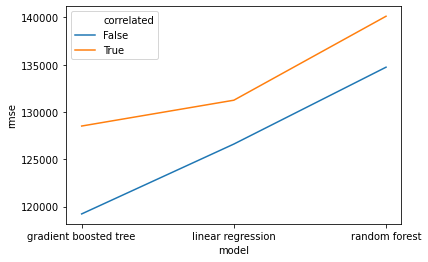

In [58]:
sns.lineplot(data=rmse_and_models_data,x='model',y='rmse',hue='correlated')

In [59]:
#take only the viable featrues from row
def make_viable_list(line):
    #("_c1","_c2","_c3","_c4","_c6","_c7","_c8","_c9","_c10","_c11","_c12","_c13","_c14","_c15","_c19","_c20")
   # row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9],row[10],row[11],row[12],row[13],row[14],row[15]
    return [line[1],line[2],line[3],line[4],line[6],line[7],line[8],line[9],line[10],line[11],line[12],line[13],line[14],line[15],line[19],line[20]]

In [60]:
#modifate 1 row 
def modifate_row(row):
    row=concat_tuples(row,get_date_details(row[0]))
    row= delete_row(row,0)
    # converting all the strings to floating
    row=convert_to_numbers(row)#maybe i will delete it later
    row=concat_tuples(row,add_boolean_renovated(row[12]))
    
    #row=concat_tuples(row,add_boolean_renovated(row[13]))
    row=delete_row(row,12)
    #print(row)
    row=concat_tuples(row,transform_to_oneHotEncoder(row[14]))
    row=delete_row(row,14)
    return row

#row.rdd.map(lambda row: [Vectors.dense(row[1:]),row[0]]).toDF(['features','label'])
                                                



In [61]:
row=['20150324T000000', '757500', '4', '2.5', '6845', '2', '0', '0', '3', '9', '3420', '0', '2009', '0','3202','2323']
row=modifate_row(row)
print(len(row))

28


In [62]:
get_date_details('20150324T000000')

[3]

In [63]:
def transformData_for_prediction(row):
    return spark.createDataFrame([(Vectors.dense(row[1:]),row[0])],["features","label"])
    


In [64]:
#prediction for a single row 
row=['20150324T000000', '757500', '4', '2.5', '6845', '2', '0', '0', '3', '9', '3420', '0', '2009', '0','3202','2323']
row=modifate_row(row)
print(row)
row= transformData_for_prediction(row)
#print(row)
#print(row.show())
pred=gbt_model.transform(row)
#print(pred)
#pred.show()
#pred.show()
prediction=pred.select("features","label","prediction").collect()
print(f'features = {prediction[0].features}\nlabel= {prediction[0].label}\nprediction = {prediction[0].prediction}')
#print(pred.predic)
#print(row)


(757500.0, 4.0, 2.5, 6845.0, 2.0, 0.0, 0.0, 3.0, 9.0, 3420.0, 0.0, 2009.0, 3202.0, 2323.0, 0.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
features = [4.0,2.5,6845.0,2.0,0.0,0.0,3.0,9.0,3420.0,0.0,2009.0,3202.0,2323.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
label= 757500.0
prediction = 658620.1835505296


In [ ]:
from pyspark import SparkContext
from kafka import KafkaConsumer
from json import loads

consumer = KafkaConsumer(
    'sales',
     bootstrap_servers=['localhost:9092'],
     auto_offset_reset='earliest',
     enable_auto_commit=True,
     group_id='my-group',
     value_deserializer=lambda x: loads(x.decode('utf-8')))

data = []
for message in consumer:
 
    message = message.value
    message = ','.join(message)
    message = list(message.split(","))
    message = make_viable_list(message)
    message =modifate_row(message)
    message= transformData_for_prediction(message)
    pred=gbt_model.transform(message)
    prediction=pred.select("features","label","prediction").collect()
    print(f'features = {prediction[0].features}\nprice= {prediction[0].label}\nprediction = {prediction[0].prediction}\n')
    #print(pred.show())
    #rdd = sc.parallelize(message) # make rdd
    #rdd= change_rdd(rdd)
    #print(rdd.collect())
    
 #   data.append(message)
   # print(data) 
  #  rdd = sc.parallelize(data) # make rdd
    #print(rdd.collect())
 


features = [3.0,2.5,1452.0,2.5,0.0,0.0,3.0,9.0,1240.0,330.0,2007.0,1670.0,1596.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
price= 547000.0
prediction = 644060.3435081143

features = [3.0,2.5,6604.0,2.0,0.0,0.0,3.0,7.0,1930.0,0.0,2014.0,910.0,6604.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
price= 550000.0
prediction = 300951.92449239956

features = [3.0,2.0,8100.0,1.0,0.0,0.0,3.0,7.0,1060.0,530.0,1996.0,1590.0,8100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]
price= 250000.0
prediction = 352625.85592962266

features = [4.0,4.5,7746.0,2.0,0.0,0.0,3.0,10.0,3720.0,0.0,2014.0,3080.0,11067.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
price= 960000.0
prediction = 782610.5167809584

features = [3.0,2.5,1891.0,3.0,0.0,0.0,3.0,9.0,1990.0,0.0,2012.0,1990.0,3600.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
price= 1080000.0
prediction = 657765.8727425036

features = [5.0,3.25,4900.0,2.0,0.0,2.0,3.0,9.0,2500.0,840.0,2014.0,3220